In [50]:
import torch; torch.manual_seed(0)
from torch import nn
from torch.nn.functional import relu
import torchvision
import matplotlib.pyplot as plt
import math 

from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device} device")

Using cuda device


# MINST DATASET

In [51]:
train_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=True, 
    download=True, 
    transform=torchvision.transforms.ToTensor()
)

val_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=False, 
    download=True, 
    transform=torchvision.transforms.ToTensor()
)

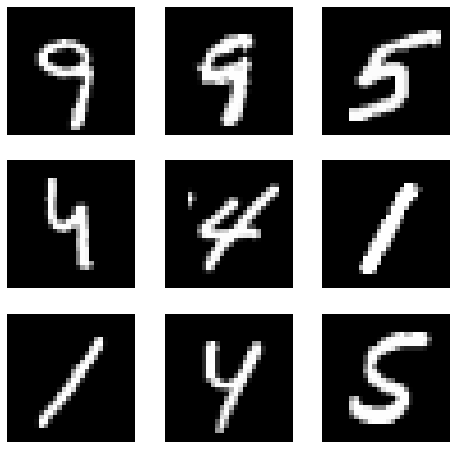

In [52]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [53]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=True)

# Model

In [54]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims=2):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 256)
        self.linear2 = nn.Linear(256, 256)
        self.linear_mu = nn.Linear(256, latent_dims)
        self.linear_sigma = nn.Linear(256, latent_dims)

        self.N = torch.distributions.Normal(torch.zeros(latent_dims), torch.ones(latent_dims))
        self.N.loc = self.N.loc.to(device)
        self.N.scale = self.N.scale.to(device)
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = relu(self.linear1(x))
        x = relu(self.linear2(x))
        mu = self.linear_mu(x)
        sigma = self.linear_sigma(x).exp()

        z = mu + sigma*self.N.sample()
        self.kl = 1/2 * (sigma**2 + mu**2 - torch.log(sigma ** 2) - 1).sum()
        return z

In [55]:
class Decoder(nn.Module):
    def __init__(self, latent_dims=2):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 256)
        self.linear2 = nn.Linear(256, 256)
        self.linear3 = nn.Linear(256, 784)
        self.sigma = nn.Parameter(torch.ones(1))

    def forward(self, z):
        z = relu(self.linear1(z))
        z = relu(self.linear2(z))
        z = torch.sigmoid(self.linear3(z))
        return z.reshape((-1, 1, 28, 28))

In [56]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims=2):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

# Plotting functions

In [57]:
def plot_latent(vae, dataloader, num_batches=100):
    plt.figure(figsize=(10, 10))
    
    for i, (x, y) in enumerate(dataloader):
        z = vae.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break
    plt.show()

In [58]:
def plot_reconstructed(vae, originals):
    fig, axes = plt.subplots(2, len(originals), figsize=(25, 5))
    
    for i in range(len(originals)):
        axes[1, i].imshow(vae(originals[i].to(device)).reshape(28, 28).to('cpu').detach().numpy())
        axes[0, i].imshow(originals[i].squeeze().numpy())
        
    plt.show()

In [59]:
def plot_generated(vae, samples):
    fig, axes = plt.subplots(1, len(samples), figsize=(25, 5))
    
    imgs = vae.decoder(samples.to(device)).reshape(len(samples), 28, 28).to('cpu').detach().numpy()
    
    for i in range(len(samples)):
        axes[i].imshow(imgs[i])
        axes[i].set_title(f"{samples[i][0].item():.1f}, {samples[i][1].item():.1f}")
        
    plt.show()

# Training

In [65]:
# def elbo_manual(X, mu, sigma, kl):
# #     logvar_rec = sigma * torch.ones_like(mu)  # replicate scalar logvar_rec to create diagonal shaped as mu_rec
#     log_prob = - torch.sum(sigma + 1/2 * ((X.squeeze() - mu) / sigma.exp()) ** 2 + math.log(math.sqrt(2 * math.pi)))
# #     if  log_prob > 0:
# #         print('log prob', log_prob)
# #         print('kl', kl)
# #         print(sigma)
# #         print(sigma.exp())
# #         print(X)
# #         print(mu)
        
#     return (log_prob - kl) / len(X)

def elbo(X, mu, sigma, kl):
    return (torch.distributions.Normal(mu, sigma.exp()).log_prob(X.squeeze()).sum() - kl) / len(X)

def loss_fn(X, mu, sigma, kl):
    return -elbo_manual(X, mu, sigma, kl)
    
#   return sigma.log() * 784 + (((X - pred) ** 2).sum() / sigma + kl) / len(pred)

In [66]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    l = 0
    for batch, (X, _) in enumerate(dataloader):
        X = X.to(device)
        optimizer.zero_grad()

        pred = model(X)

        loss = loss_fn(X, pred.squeeze(), model.decoder.sigma, model.encoder.kl)
        l += loss.item()

        loss.backward()
        optimizer.step()
    
    l /= len(dataloader)
    return l

In [67]:
def test(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, _ in dataloader:
            X = X.to(device)
            pred = model(X)
            test_loss += loss_fn(X, pred.squeeze(), model.decoder.sigma, model.encoder.kl).item()
    test_loss /= num_batches
    
    return test_loss

## Task 3: Train and Plot every 25 epochs

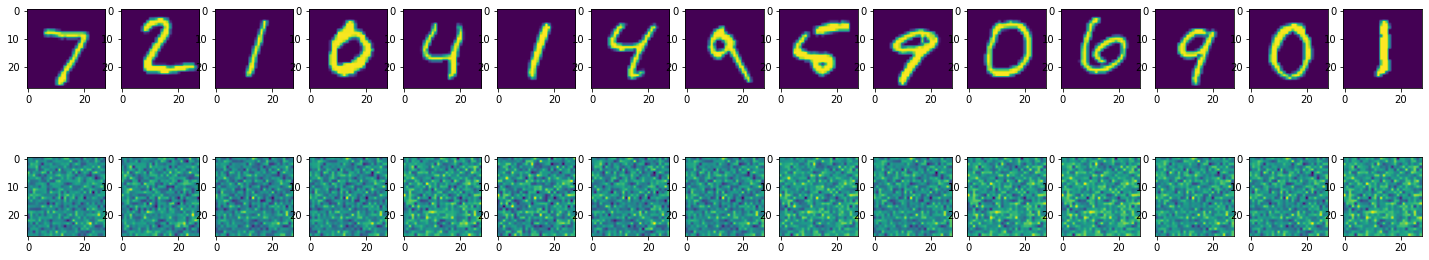

Epoch 1
-------------------------------
Train Error: Avg loss: 1327.104270 

Test Error: Avg loss: 1146.473763 



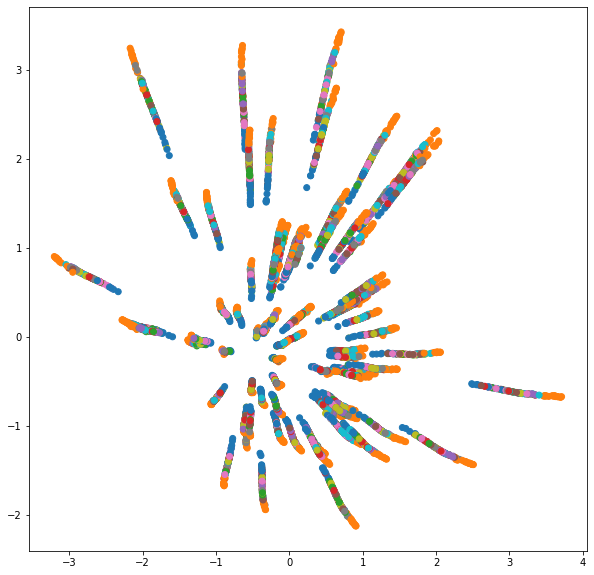

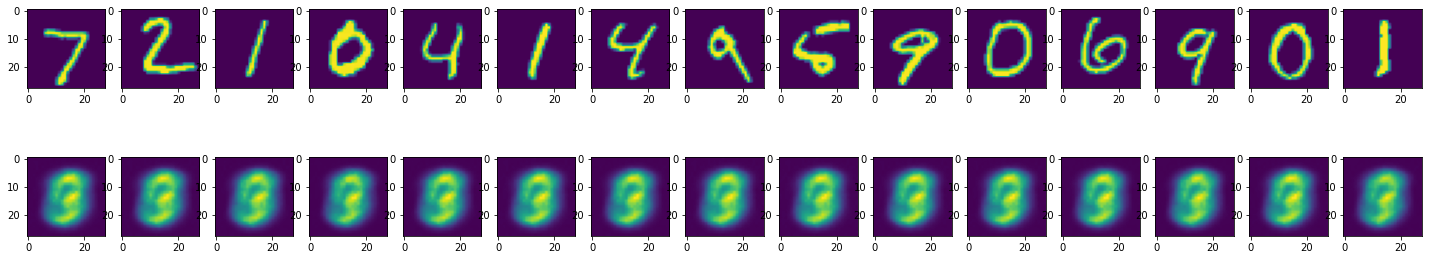

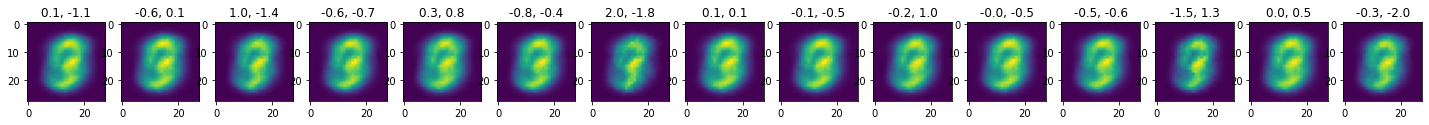

Epoch 11
-------------------------------
Train Error: Avg loss: -154.361105 

Test Error: Avg loss: -155.255959 

Epoch 21
-------------------------------
Train Error: Avg loss: -169.271878 

Test Error: Avg loss: -162.962639 



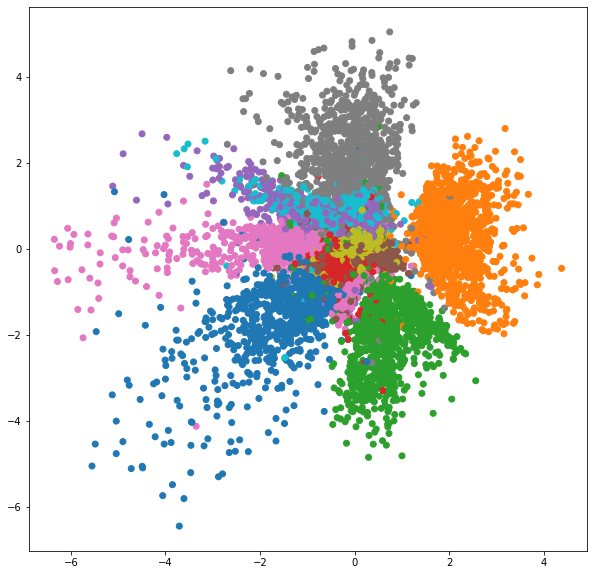

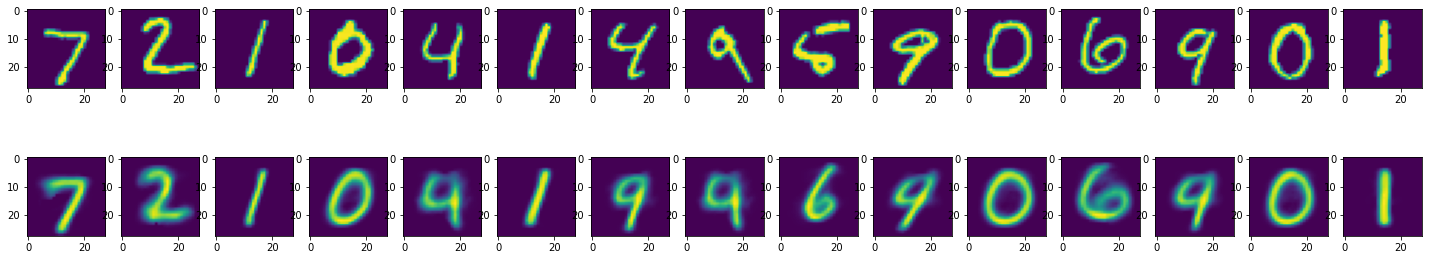

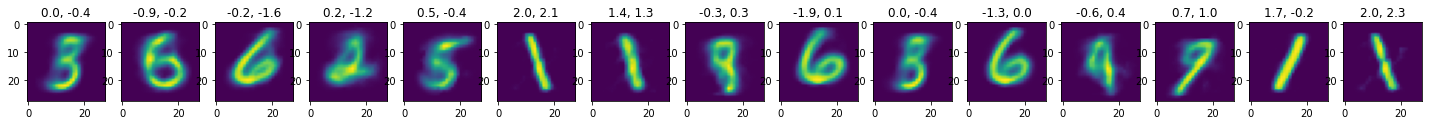

Epoch 31
-------------------------------
Train Error: Avg loss: -175.509902 

Test Error: Avg loss: -173.082062 

Epoch 41
-------------------------------
Train Error: Avg loss: -179.819558 

Test Error: Avg loss: -169.289378 

Epoch 51
-------------------------------
Train Error: Avg loss: -183.593853 

Test Error: Avg loss: -177.946165 



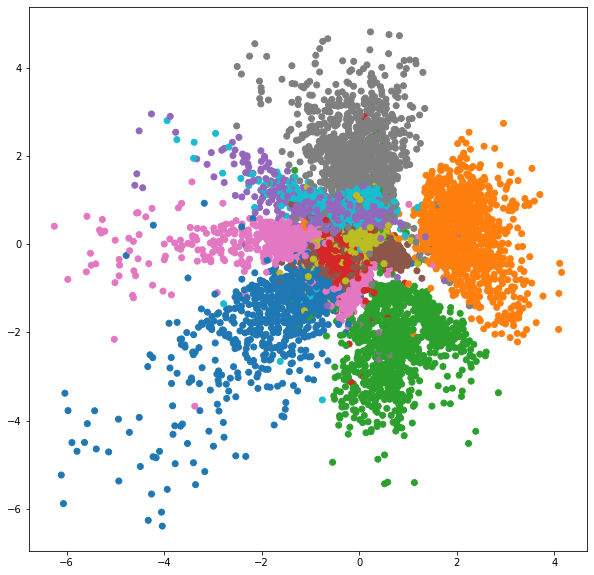

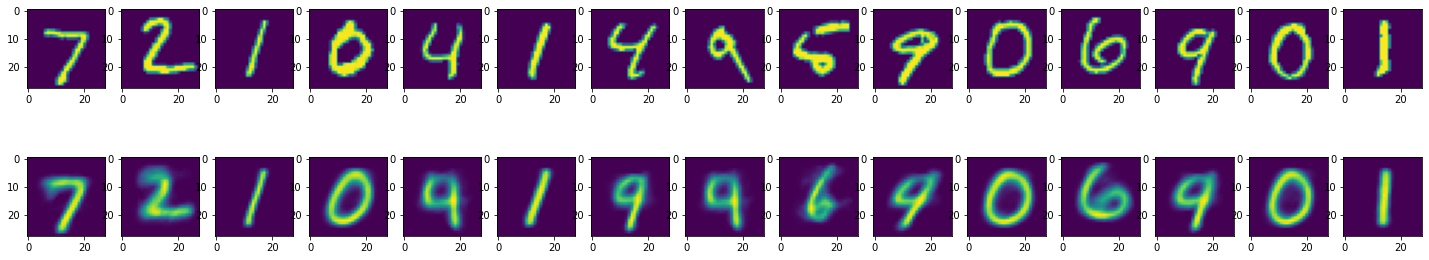

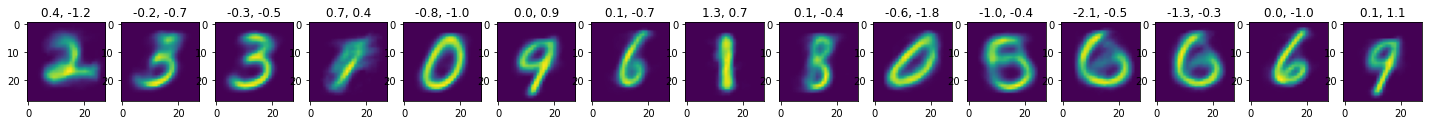

Epoch 61
-------------------------------
Train Error: Avg loss: -185.438384 

Test Error: Avg loss: -178.096632 

Epoch 71
-------------------------------
Train Error: Avg loss: -187.982923 

Test Error: Avg loss: -180.028087 



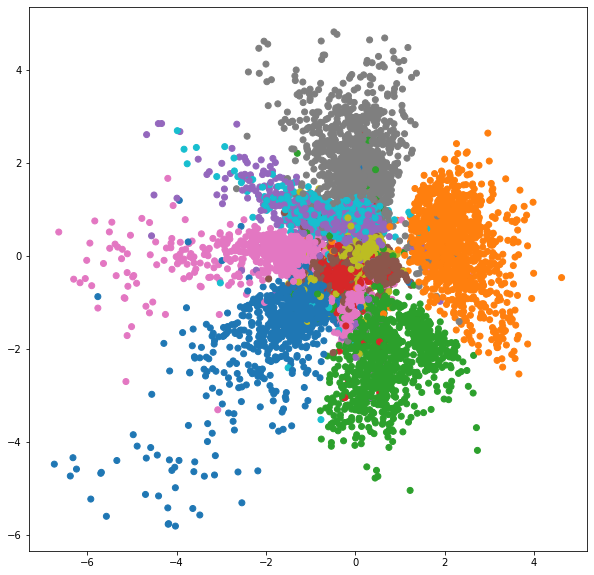

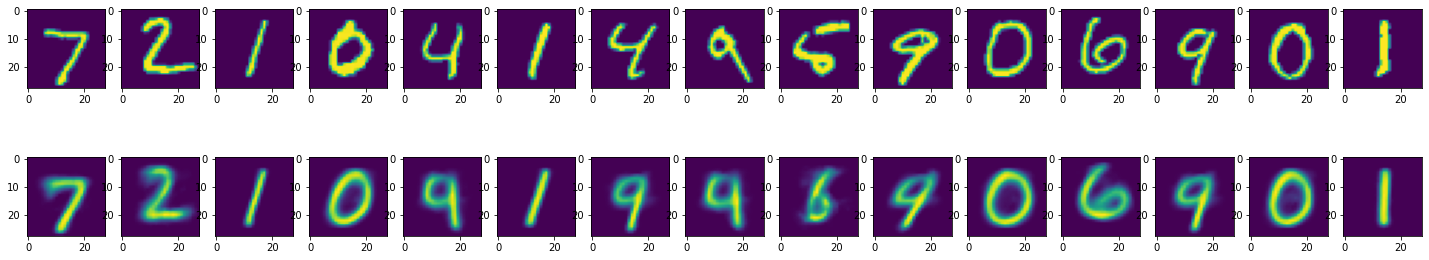

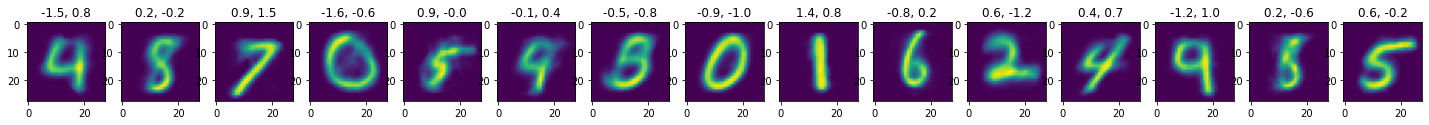

Epoch 81
-------------------------------
Train Error: Avg loss: -189.619259 

Test Error: Avg loss: -180.828826 

Epoch 91
-------------------------------
Train Error: Avg loss: -191.108753 

Test Error: Avg loss: -181.255944 

Epoch 101
-------------------------------
Train Error: Avg loss: -192.482227 

Test Error: Avg loss: -181.986129 



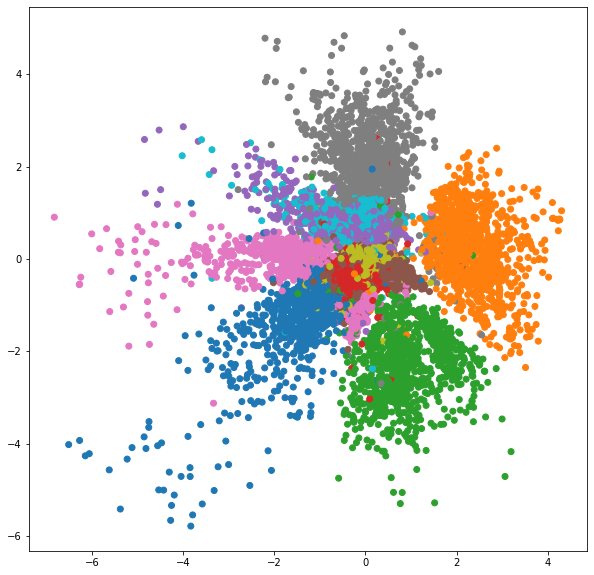

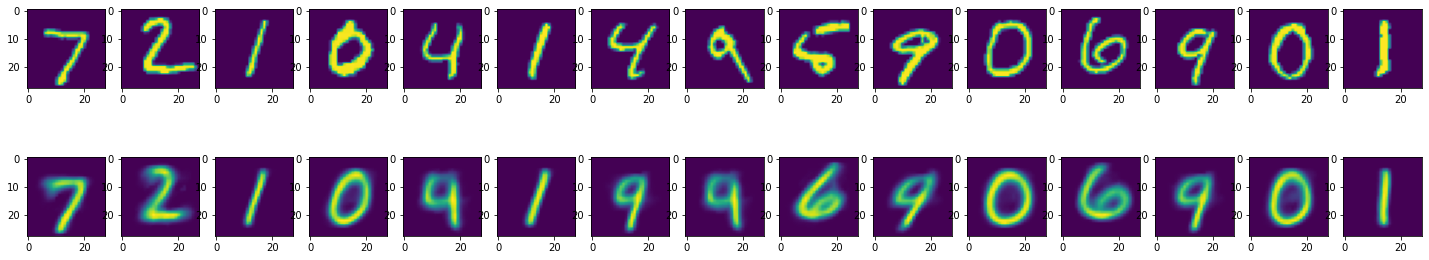

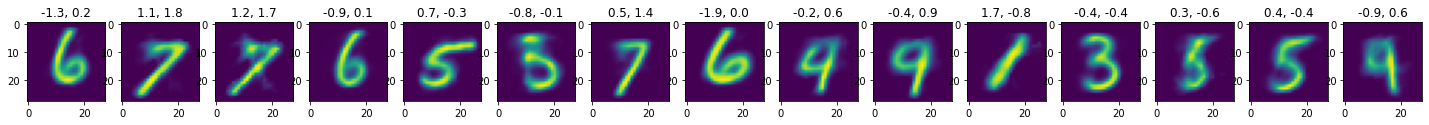

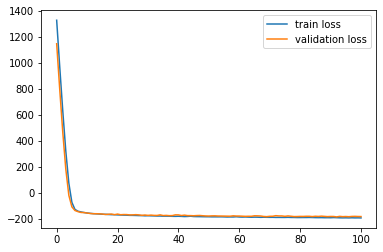

Done!


In [122]:
vae = VariationalAutoencoder(2).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
train_losses = []
val_losses = []
epochs = 101

plot_reconstructed(vae, [val_dataset[i][0] for i in range(15)])

for t in range(epochs):
    train_losses.append(train_one_epoch(train_dataloader, vae, loss_fn, optimizer))
    val_losses.append(test(val_dataloader, vae, loss_fn))
    
    if t % 10 == 0:
        print(f"Epoch {t+1}\n-------------------------------")
        print(f"Train Error: Avg loss: {train_losses[-1]:>8f} \n")
        print(f"Test Error: Avg loss: {val_losses[-1]:>8f} \n")

    if t % 25 == 0:
        plot_latent(vae, val_dataloader)
        plot_reconstructed(vae, [val_dataset[i][0] for i in range(15)])
        plot_generated(vae, torch.normal(mean=0, std=1, size=(15, 2)))

plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()
plt.show()

print("Done!")

## Task 5

Epoch 1
-------------------------------
Train Error: Avg loss: 1327.098072 

Test Error: Avg loss: 1146.479358 

Epoch 11
-------------------------------
Train Error: Avg loss: -402.952323 

Test Error: Avg loss: -426.404582 

Epoch 21
-------------------------------
Train Error: Avg loss: -538.471489 

Test Error: Avg loss: -549.689538 

Epoch 31
-------------------------------
Train Error: Avg loss: -595.212058 

Test Error: Avg loss: -589.383520 

Epoch 41
-------------------------------
Train Error: Avg loss: -628.185835 

Test Error: Avg loss: -631.408703 

Epoch 51
-------------------------------
Train Error: Avg loss: -647.631343 

Test Error: Avg loss: -634.249631 

Epoch 61
-------------------------------
Train Error: Avg loss: -667.179640 

Test Error: Avg loss: -656.996118 

Epoch 71
-------------------------------
Train Error: Avg loss: -677.721947 

Test Error: Avg loss: -644.949206 

Epoch 81
-------------------------------
Train Error: Avg loss: -688.325205 

Test Error:

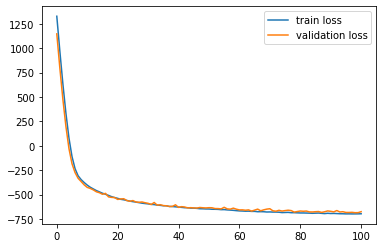

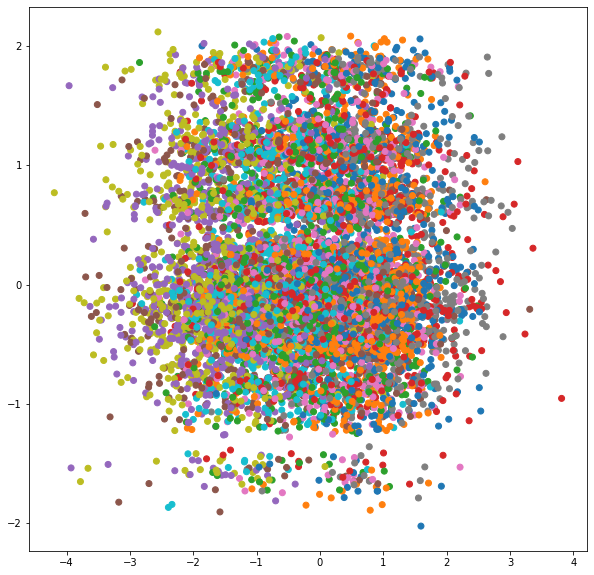

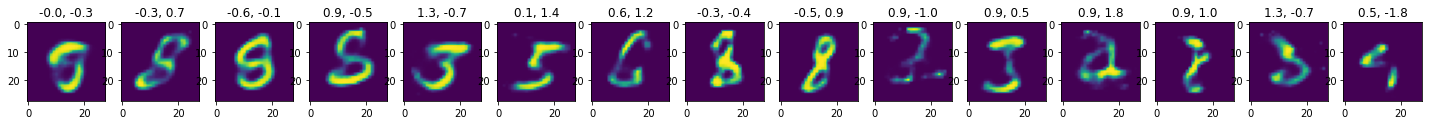

Done!


In [124]:
vae2 = VariationalAutoencoder(32).to(device)
opt = torch.optim.Adam(vae2.parameters(), lr=1e-3)

train_losses2 = []
val_losses2 = []

epochs = 101

for t in range(epochs):
    train_losses2.append(train_one_epoch(train_dataloader, vae2, loss_fn, opt))
    val_losses2.append(test(val_dataloader, vae2, loss_fn))
    
    if t % 10 == 0:
        print(f"Epoch {t+1}\n-------------------------------")
        print(f"Train Error: Avg loss: {train_losses2[-1]:>8f} \n")
        print(f"Test Error: Avg loss: {val_losses2[-1]:>8f} \n")
        
plt.plot(train_losses2, label='train loss')
plt.plot(val_losses2, label='validation loss')
plt.legend()
plt.show()

# plot_latent(vae2, val_dataloader)
plot_generated(vae2, torch.normal(mean=0, std=3, size=(15, 32)))

print("Done!")

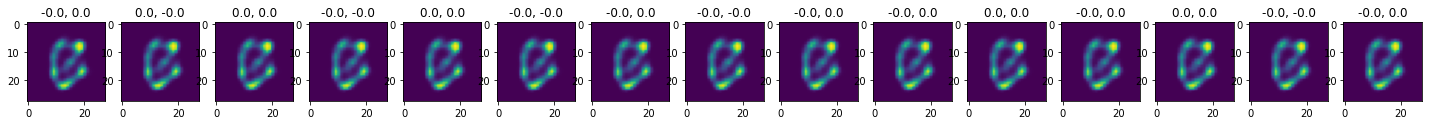

In [127]:
plot_generated(vae2, torch.normal(mean=0, std=5, size=(15, 32)))